**8. Quantization**

In [ ]:
# Dataset
import urllib.request

dataset_url = 'https://github.com/Mithoonns2001/dataset/raw/main/animal_images.zip'

urllib.request.urlretrieve(dataset_url, '/content/animal_images.zip')

!unzip -q /content/animal_images.zip -d /content

In [ ]:
# Model 1
import urllib.request

dataset_url = 'https://github.com/Mithoonns2001/dataset/raw/main/ssd_mobilenet.zip'

urllib.request.urlretrieve(dataset_url, '/content/ssd_mobilenet.zip')

!unzip -q /content/ssd_mobilenet.zip -d /content

In [ ]:
# Model 2
import urllib.request

dataset_url = 'https://github.com/Mithoonns2001/dataset/raw/main/EfficientDet.zip'

urllib.request.urlretrieve(dataset_url, '/content/EfficientDet.zip')

!unzip -q /content/EfficientDet.zip -d /content

In [18]:
import glob
image_path = '/content/animal_images/train_image'

jpg_file_list = glob.glob(image_path + '/*.jpg')
JPG_file_list = glob.glob(image_path + '/*.JPG')
png_file_list = glob.glob(image_path + '/*.png')
bmp_file_list = glob.glob(image_path + '/*.bmp')

quant_image_list = jpg_file_list + JPG_file_list + png_file_list + bmp_file_list

In [23]:
import tensorflow as tf
from tensorflow.lite.python.interpreter import Interpreter

model_folder_name='EfficientDet'
# model_folder_name='ssd_mobilenet'

PATH_TO_MODEL=f'/content/{model_folder_name}/detect.tflite'

interpreter = Interpreter(model_path=PATH_TO_MODEL)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
height = input_details[0]['shape'][1]
width = input_details[0]['shape'][2]

import random

import random
import tensorflow as tf

def representative_data_gen():
    dataset_list = quant_image_list
    quant_num = 300
    for i in range(quant_num):
        if not dataset_list:
            break  # Break the loop if the dataset_list is empty
        pick_me = random.choice(dataset_list)
        dataset_list.remove(pick_me)  # Remove the selected item to avoid duplicates
        image = tf.io.read_file(pick_me)

        if pick_me.endswith('.jpg') or pick_me.endswith('.JPG'):
            image = tf.io.decode_jpeg(image, channels=3)
        elif pick_me.endswith('.png'):
            image = tf.io.decode_png(image, channels=3)
        elif pick_me.endswith('.bmp'):
            image = tf.io.decode_bmp(image, channels=3)

        image = tf.image.resize(image, [width, height])
        image = tf.cast(image / 255., tf.float32)
        image = tf.expand_dims(image, 0)
        yield [image]


In [ ]:
# Converter module
converter = tf.lite.TFLiteConverter.from_saved_model(f'/content/{model_folder_name}/saved_model')

converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

converter.target_spec.supported_types = [tf.int8]

converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.float32
tflite_model = converter.convert()

with open(f'/content/{model_folder_name}/detect_quant.tflite', 'wb') as f:
  f.write(tflite_model)

In [24]:

import os
import cv2
import numpy as np
import sys
import glob
import random
from tensorflow.lite.python.interpreter import Interpreter

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

def tflite_detect_images_dual_models(modelpath_1, modelpath_2, imgpath, lblpath, min_conf=0.5, num_test_images=10, savepath='/content/results', txt_only=False):

    images = glob.glob(imgpath + '/*.jpg') + glob.glob(imgpath + '/*.JPG') + glob.glob(imgpath + '/*.png') + glob.glob(imgpath + '/*.bmp')

    with open(lblpath, 'r') as f:
        labels = [line.strip() for line in f.readlines()]

    interpreter_1 = Interpreter(model_path=modelpath_1)
    interpreter_1.allocate_tensors()

    interpreter_2 = Interpreter(model_path=modelpath_2)
    interpreter_2.allocate_tensors()

    input_details_1 = interpreter_1.get_input_details()
    output_details_1 = interpreter_1.get_output_details()
    height_model_1, width_model_1 = input_details_1[0]['shape'][1], input_details_1[0]['shape'][2]

    input_details_2 = interpreter_2.get_input_details()
    output_details_2 = interpreter_2.get_output_details()
    height_model_2, width_model_2 = input_details_2[0]['shape'][1], input_details_2[0]['shape'][2]

    float_input_1 = (input_details_1[0]['dtype'] == np.float32)
    float_input_2 = (input_details_2[0]['dtype'] == np.float32)

    # images_to_test = imgpath # for single path

    images_to_test = random.sample(images, num_test_images)

    for image_path in images_to_test:
        image = cv2.imread(image_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        imH, imW, _ = image.shape

        # Model 1
        input_frame_1 = cv2.resize(image_rgb, (width_model_1, height_model_1))
        input_data_1 = np.expand_dims(input_frame_1, axis=0)

        if float_input_1:
            input_data_1 = (np.float32(input_data_1) - 127.5) / 127.5

        interpreter_1.set_tensor(input_details_1[0]['index'], input_data_1)
        interpreter_1.invoke()

        # Result for Model 1
        boxes_1 = interpreter_1.get_tensor(output_details_1[1]['index'])[0]
        classes_1 = interpreter_1.get_tensor(output_details_1[3]['index'])[0]
        scores_1 = interpreter_1.get_tensor(output_details_1[0]['index'])[0]

        # Model 2
        input_frame_2 = cv2.resize(image_rgb, (width_model_2, height_model_2))
        input_data_2 = np.expand_dims(input_frame_2, axis=0)

        if float_input_2:
            input_data_2 = (np.float32(input_data_2) - 127.5) / 127.5

        interpreter_2.set_tensor(input_details_2[0]['index'], input_data_2)
        interpreter_2.invoke()

        # Result for Model 2
        boxes_2 = interpreter_2.get_tensor(output_details_2[1]['index'])[0]
        classes_2 = interpreter_2.get_tensor(output_details_2[3]['index'])[0]
        scores_2 = interpreter_2.get_tensor(output_details_2[0]['index'])[0]

        detections_1 = []
        detections_2 = []

        for i in range(len(scores_1)):
            if (scores_1[i] > min_conf) and (scores_1[i] <= 1.0):
                ymin, xmin, ymax, xmax = boxes_1[i]
                detections_1.append([labels[int(classes_1[i])], scores_1[i], int(xmin * width_model_1), int(ymin * height_model_1), int(xmax * width_model_1), int(ymax * height_model_1)])

        for i in range(len(scores_2)):
            if (scores_2[i] > min_conf) and (scores_2[i] <= 1.0):
                ymin, xmin, ymax, xmax = boxes_2[i]
                detections_2.append([labels[int(classes_2[i])], scores_2[i], int(xmin * width_model_2), int(ymin * height_model_2), int(xmax * width_model_2), int(ymax * height_model_2)])

        if txt_only == False:
            plt.figure(figsize=(12, 6))

            # Display results for Model 1
            plt.subplot(1, 2, 1)
            plt.imshow(image_rgb)
            plt.title("Original Model")
            for detection in detections_1:
                xmin, ymin, xmax, ymax = detection[2:]
                xmin = int(xmin * imW / width_model_1)
                xmax = int(xmax * imW / width_model_1)
                ymin = int(ymin * imH / height_model_1)
                ymax = int(ymax * imH / height_model_1)
                plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='red', linewidth=2))
                plt.text(xmin, ymin, f"{detection[0]}: {detection[1]:.2f}", color='red', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

            # Display results for Model 2
            plt.subplot(1, 2, 2)
            plt.imshow(image_rgb)
            plt.title("Quantization Model")
            for detection in detections_2:
                xmin, ymin, xmax, ymax = detection[2:]
                xmin = int(xmin * imW / width_model_2)
                xmax = int(xmax * imW / width_model_2)
                ymin = int(ymin * imH / height_model_2)
                ymax = int(ymax * imH / height_model_2)
                plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, edgecolor='blue', linewidth=2))
                plt.text(xmin, ymin, f"{detection[0]}: {detection[1]:.2f}", color='blue', fontsize=8, bbox=dict(facecolor='white', alpha=0.7))

            plt.show()


        elif txt_only == True:
            image_fn = os.path.basename(image_path)
            base_fn, ext = os.path.splitext(image_fn)
            txt_result_fn_1 = base_fn + '_model1.txt'
            txt_result_fn_2 = base_fn + '_model2.txt'
            txt_savepath_1 = os.path.join(savepath, txt_result_fn_1)
            txt_savepath_2 = os.path.join(savepath, txt_result_fn_2)

            with open(txt_savepath_1, 'w') as f1:
                for detection in detections_1:
                    f1.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

            with open(txt_savepath_2, 'w') as f2:
                for detection in detections_2:
                    f2.write('%s %.4f %d %d %d %d\n' % (detection[0], detection[1], detection[2], detection[3], detection[4], detection[5]))

    return


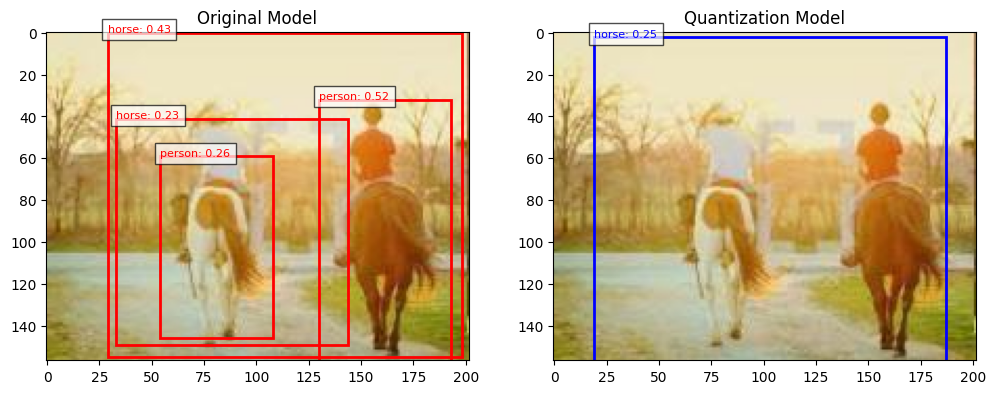

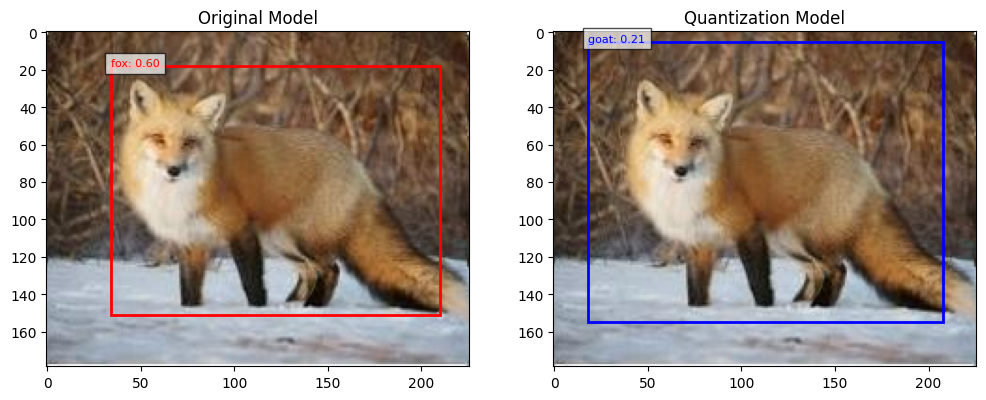

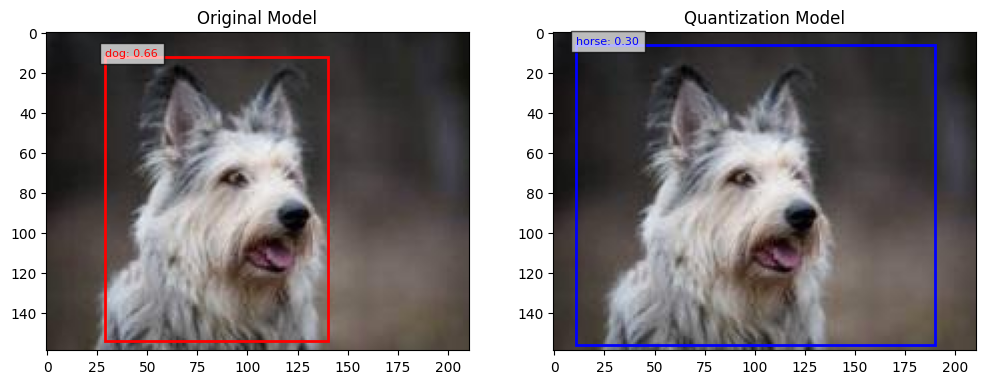

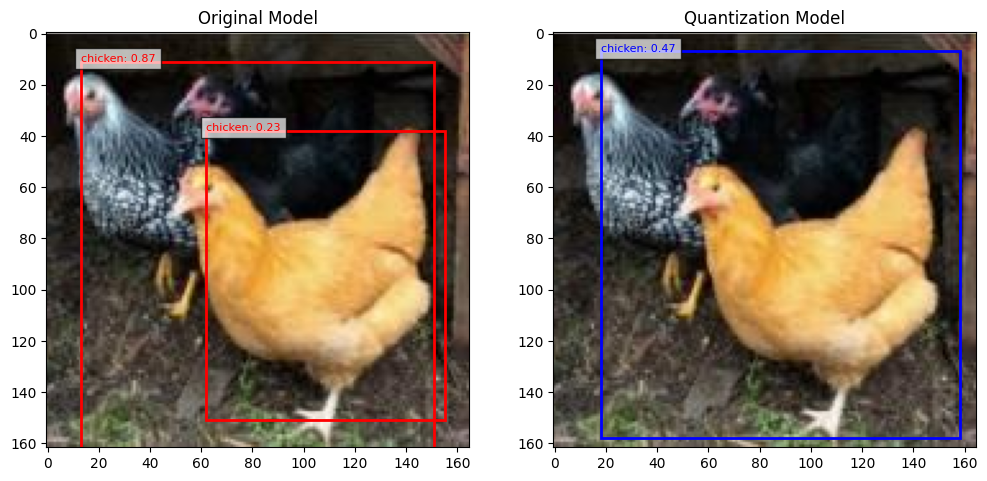

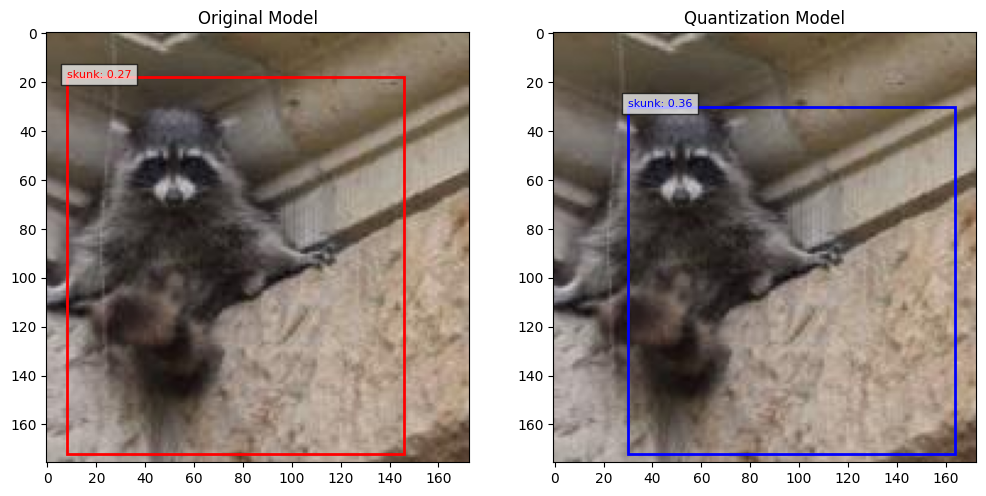

In [27]:

PATH_TO_IMAGES = '/content/animal_images/test_image'
PATH_TO_MODEL_1 = f'/content/{model_folder_name}/detect.tflite'
PATH_TO_MODEL_2 = f'/content/{model_folder_name}/detect_quant.tflite'
PATH_TO_LABELS = '/content/animal_images/label_map.txt'
min_conf_threshold = 0.2
images_to_test = 5

tflite_detect_images_dual_models(PATH_TO_MODEL_1, PATH_TO_MODEL_2, PATH_TO_IMAGES, PATH_TO_LABELS, min_conf_threshold, images_to_test)
